## Plots - Simulations
In this notebook, we take outputs from our simulations run and make a series of plots for the 
THOR paper. 

[Survey Footprint [Fig 5]](#Survey-Footprint)  
[Create and Propagate a Test Orbit [Fig 1]](#Create-and-Propagate-a-Test-Orbit)  
[Heliocentric Transformation and Projection [Fig 2]](#Heliocentric-Transformation-and-Projection)  
[Hough Transform [Fig 3]](#Hough-Transform)  
[Co-rotating Frame Velocities [Fig 4]](#Co-rotating-Frame-Velocities)  
[Completeness [Fig 6]](#Completeness)   
[Non-linear Velocities](#Non-linear-Velocities)  
[Cluster Summary](#Cluster-Summary)

This notebook creates Figures 1 - 6.

Data and results files for this notebook may be downloaded [here](https://dirac.astro.washington.edu/~moeyensj/projects/thor/paper1/).

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
sns.set(font_scale=1.2, context="paper", style="ticks")
sns.set_palette("viridis")

import mysql.connector as mariadb
from astropy.time import Time

from scipy.stats import binned_statistic_2d

%matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("/epyc/projects/thor/thor")

In [2]:
import thor

In [3]:
DPI = 300
SAVE_DIR = "plots/"
FORMAT = "png"

SAVE_FIGS = True

In [4]:
RUN_DIR = "/epyc/projects/thor/results/msst_4x4/run_16/"
DATABASE = "/epyc/projects/thor/data/msst_4x4/msst_survey.db"
con = sql.connect(DATABASE)

In [5]:
allObjects_survey = pd.read_csv(os.path.join(RUN_DIR, "allObjects_survey.txt"), sep=" ", index_col=False)
summary_survey = pd.read_csv(os.path.join(RUN_DIR, "summary_survey.txt"), sep=" ", index_col=False)
summary_orbits = pd.read_csv(os.path.join(RUN_DIR, "summary_orbits.txt"), sep=" ", index_col=False)
test_orbits_survey = pd.read_csv(os.path.join(RUN_DIR, "orbits.txt"), sep=" ", index_col=False)

known_orbits = pd.read_sql("SELECT * FROM mpcOrbitCat", con)
known_orbits = known_orbits[known_orbits["designation"].isin(allObjects_survey["designation"].values)]

In [6]:
findable = allObjects_survey[allObjects_survey["findable"] == 1]["designation"].values
found = allObjects_survey[allObjects_survey["found"] == 1]["designation"].values
missed = allObjects_survey[(allObjects_survey["found"] == 0) & (allObjects_survey["findable"] == 1) ]["designation"].values
test_orbits = test_orbits_survey["designation"].values

In [7]:
observationsNoNoise = pd.read_sql("""SELECT * FROM observations WHERE night < 59754""", con)
print(len(observationsNoNoise))
observationsNoNoise.drop_duplicates(subset=["designation", "exp_mjd"], inplace=True)
print(len(observationsNoNoise))
noise = pd.read_sql("""SELECT * FROM noise_100 WHERE night < 59754""", con)
noise["obsId"] = np.arange(observationsNoNoise["obsId"].values[-1] + 1, observationsNoNoise["obsId"].values[-1] + 1 + len(noise))

2315689
2313850


In [8]:
observations = pd.concat([observationsNoNoise, noise], sort=False)
observations.reset_index(inplace=True, drop=True)
del observationsNoNoise
del noise

In [9]:
survey = pd.read_sql("""SELECT * FROM survey""", con)

In [10]:
orbits = pd.read_sql("""SELECT * FROM mpcOrbitCat""", con)
# Only grab the orbits of objects with observations
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())]
orbits.drop_duplicates(subset=["designation"], inplace=True)

#### Survey Footprint

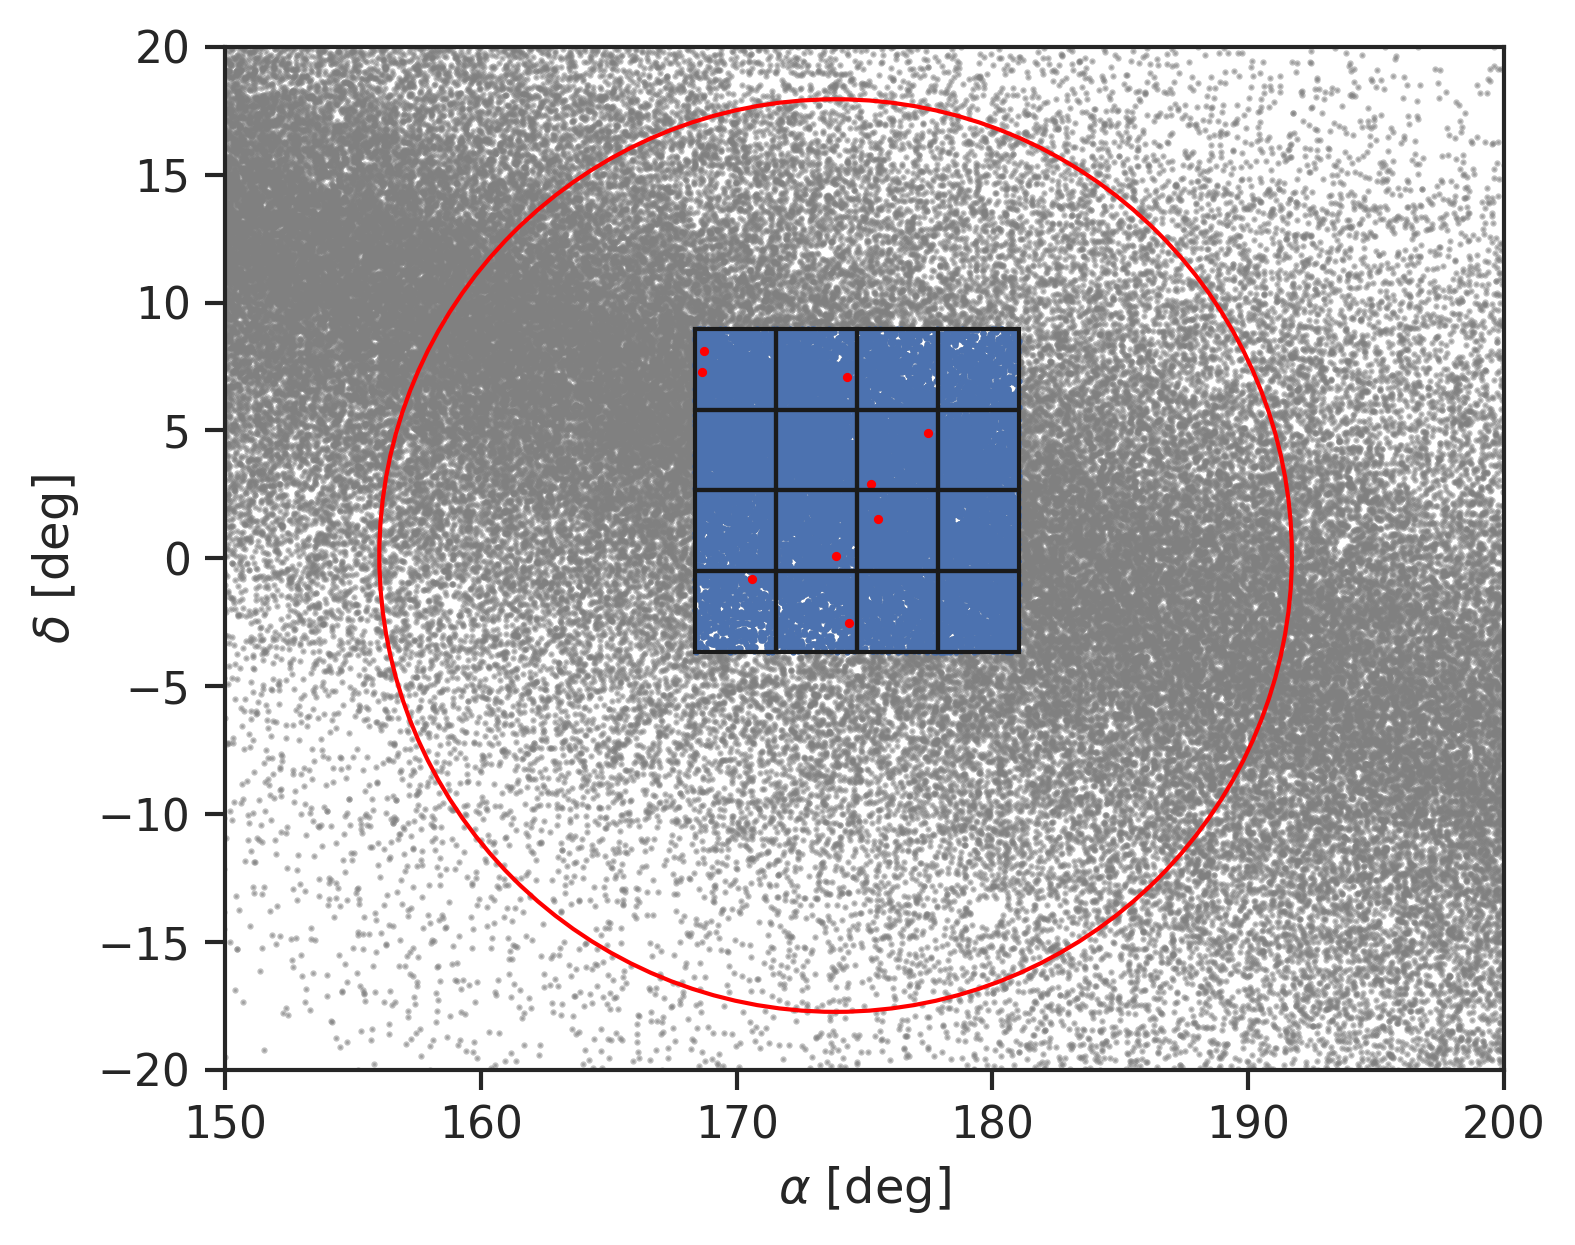

In [11]:
# Plot footprint
fieldArea = 10
xField = np.sqrt(fieldArea)
yField = np.sqrt(fieldArea)

fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(5.5, 5.5))
ax.set_xlabel(r"$\alpha$ [$\deg$]")
ax.set_ylabel(r"$\delta$ [$\deg$]")
fields = [405, 406, 407, 408, 433, 434, 435, 436, 445, 446, 447, 448, 473, 474, 475, 476]
for xx, yy in zip(survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin(fields))]["fieldRA_deg"].values, 
                  survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin(fields))]["fieldDec_deg"].values):
    ax.add_patch(patches.Rectangle((xx-xField/2, yy-yField/2), xField, yField, fill=False, lw=1, color="k"))
ax.scatter(observations[(observations["night"] == survey["night"].min()) & (observations["designation"] != "NS")]["RA_deg"].values, 
           observations[(observations["night"] == survey["night"].min()) & (observations["designation"] != "NS")]["Dec_deg"].values,
           s=0.5,
           c="#808080",
           alpha=0.5)
ax.scatter(observations[(observations["night"] == survey["night"].min()) 
                        & (observations["designation"] != "NS")
                        & (observations["fieldId"].isin(fields))]["RA_deg"].values, 
           observations[(observations["night"] == survey["night"].min()) 
                        & (observations["designation"] != "NS")
                        & (observations["fieldId"].isin(fields))]["Dec_deg"].values,
           s=0.5,
           c="b")
ax.scatter(test_orbits_survey["RA_deg"].values,
           test_orbits_survey["Dec_deg"].values,
           s=2,
           c="red")
for ra, dec in test_orbits_survey[test_orbits_survey["orbit_id"].isin([3])][["RA_deg", "Dec_deg"]].values:
    ax.add_patch(patches.Circle([ra, dec], np.sqrt(1000/np.pi), fill=False, lw=1, color="red"))

ax.set_aspect("equal")
ax.set_ylim(-20, 20)
ax.set_xlim(150, 200)
if SAVE_FIGS == True:
    fig.savefig(os.path.join(SAVE_DIR, "simulations_footprint.{}".format(FORMAT)),
            bbox_inches='tight')

In [12]:
fields = [405, 406, 407, 408, 433, 434, 435, 436, 445, 446, 447, 448, 473, 474, 475, 476]
observations = observations[observations["fieldId"].isin(fields)]

In [13]:
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())]
orbits.drop_duplicates(subset="designation", inplace=True)

### Create and Propagate a Test Orbit 

In [14]:
average_object = thor.findAverageOrbits(observations, orbits, dValues=[2.9, 3])

THOR: findAverageObject
-------------------------
Finding average orbit in 1 distance bins...
Done.
-------------------------



In [15]:
average_object

orbit_id      r_au  HEclObj_dX/dt_au_p_day  HEclObj_dY/dt_au_p_day  \
0         1  3.237396                0.001856               -0.008887   
1         1  3.236922                0.001912               -0.008877   
2         1  3.236437                0.001967               -0.008866   
3         1  3.235942                0.002022               -0.008855   
4         1  3.235435                0.002078               -0.008843   
5         1  3.234919                0.002133               -0.008832   
6         1  3.234393                0.002189               -0.008820   

   HEclObj_dZ/dt_au_p_day       exp_mjd      RA_deg   Dec_deg      a_au  \
0               -0.000720  59740.238889  173.690623  5.035741  2.963106   
1               -0.000722  59742.238889  173.942092  4.877238  2.963106   
2               -0.000724  59744.238889  174.207906  4.713315  2.963106   
3               -0.000726  59746.238889  174.487654  4.544137  2.963106   
4               -0.000728  59748.246528  174.782119  4.369173  2.963106   
5               -0.000729  59750.246528  175.088703  4.189889  2.963106   
6               -0.000731  59752.246528  175.408183  4.005748  2.963106   

     i_deg        e designation  
0  4.90315  0.09605       97142  
1  4.90315  0.09605       97142  
2  4.90315  0.09605       97142  
3  4.90315  0.09605       97142  
4  4.90315  0.09605       97142  
5  4.90315  0.09605       97142  
6  4.90315  0.09605       97142

In [16]:
no_noise = (~observations["designation"].isin(["NS"]))

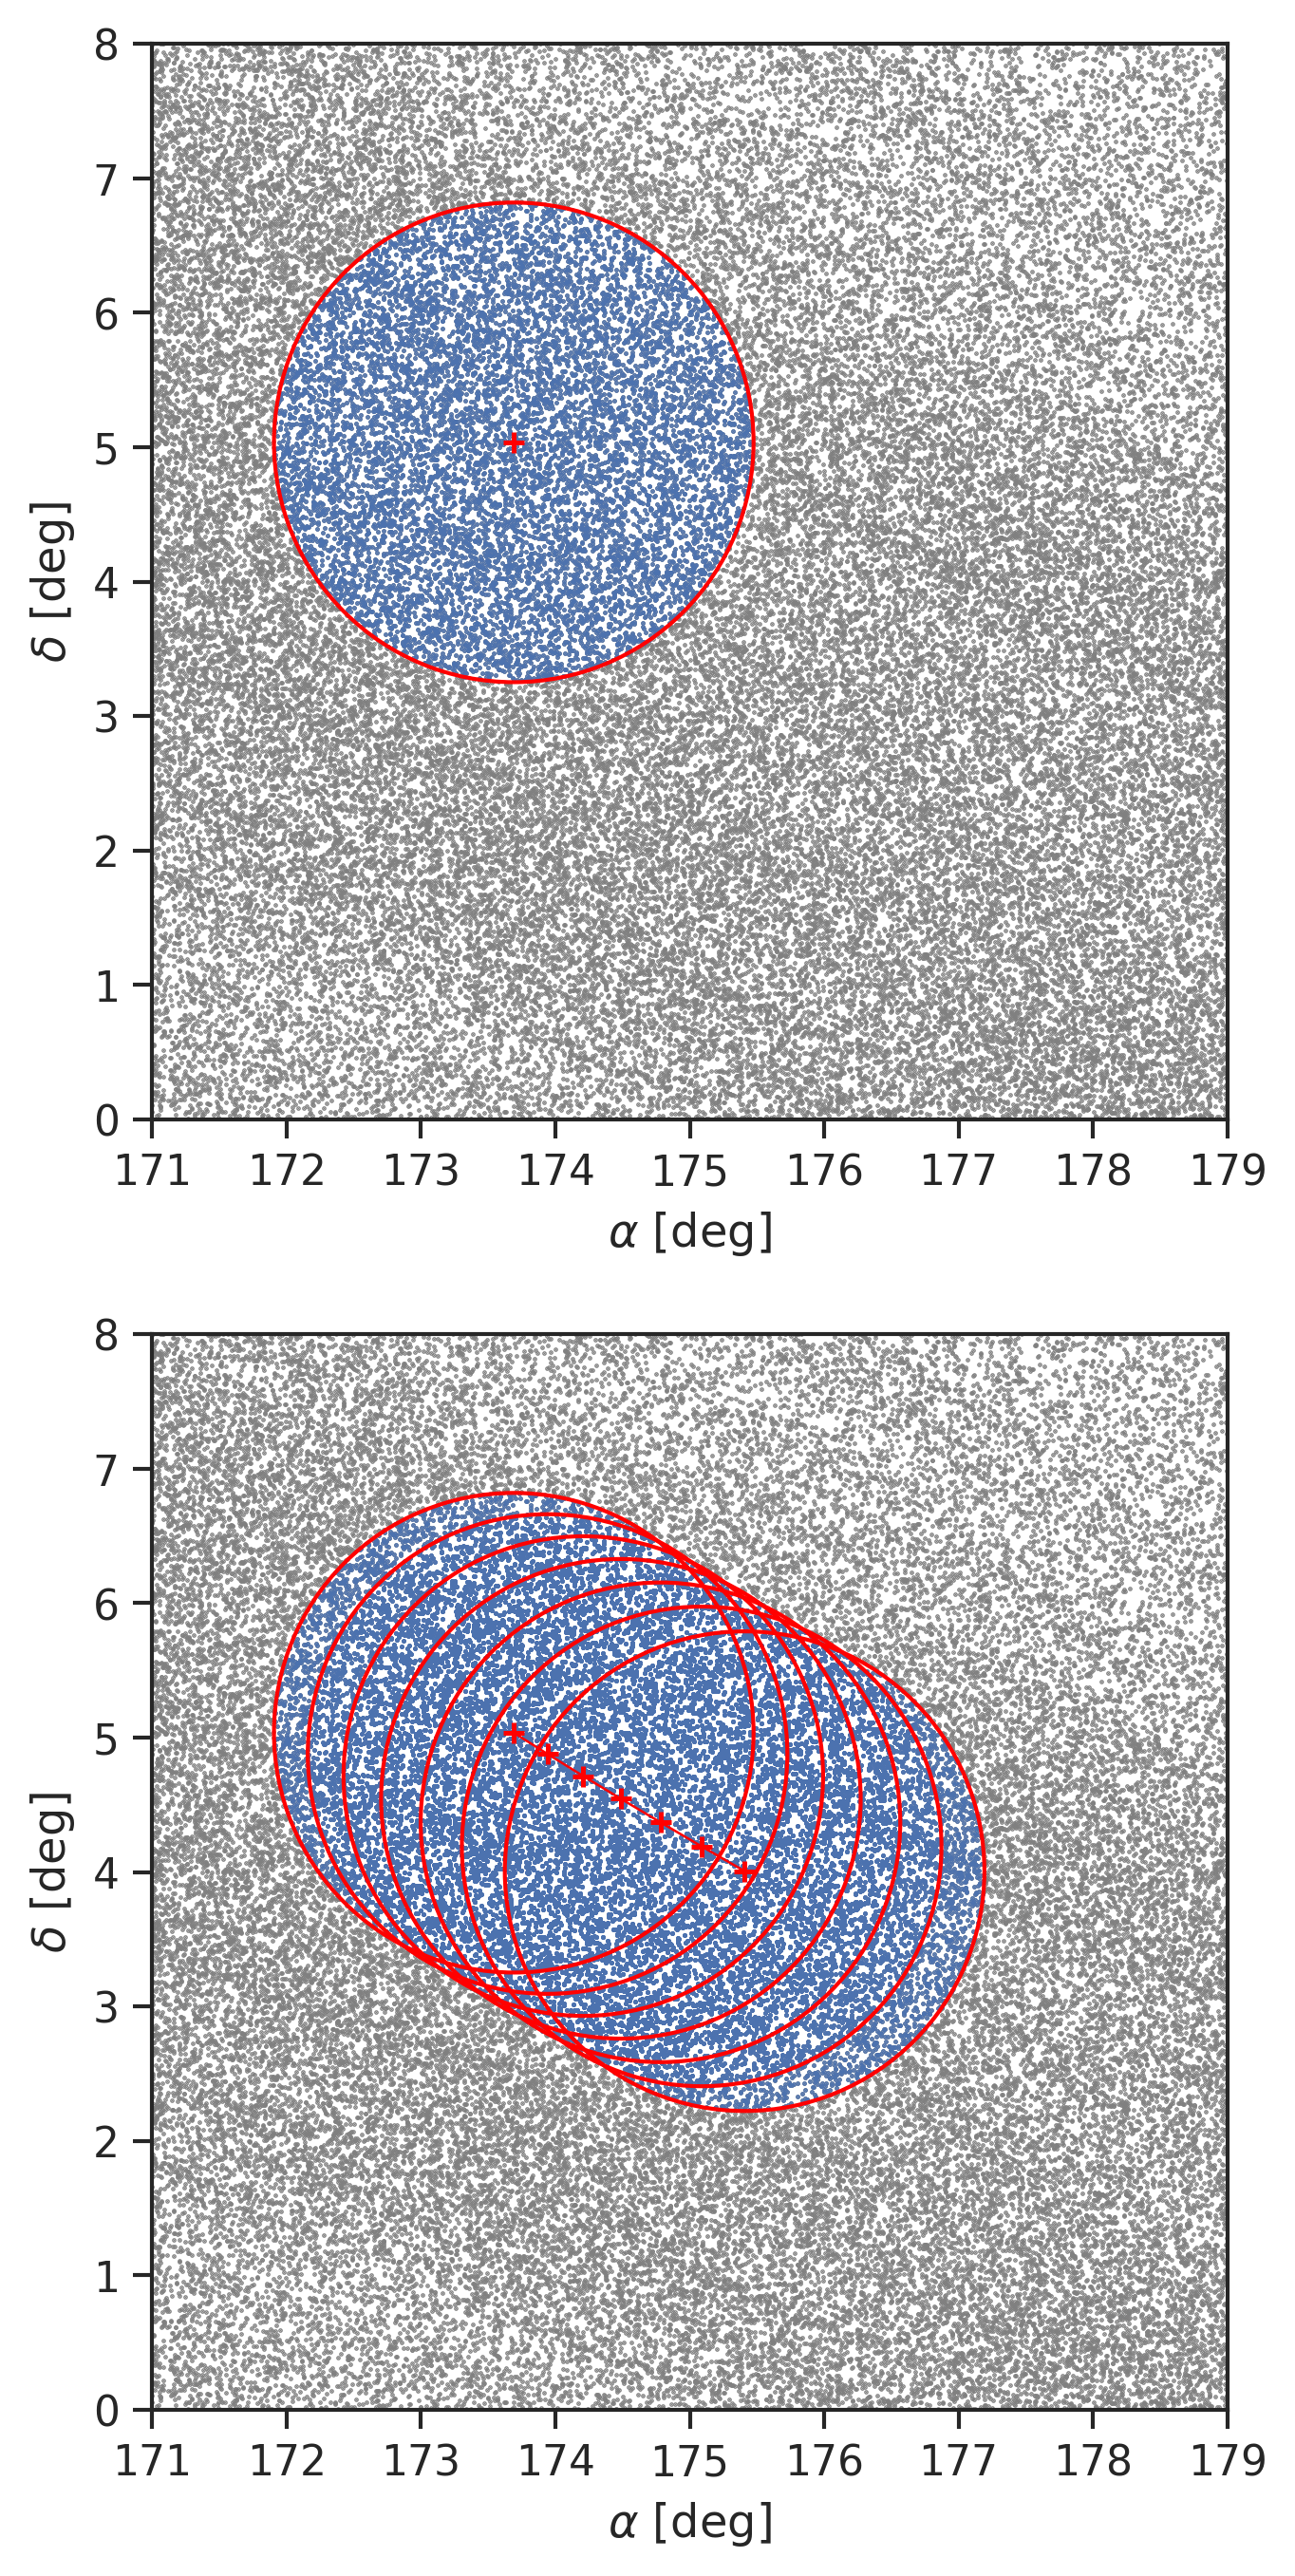

In [17]:
fig, ax = plt.subplots(2, 1, dpi=DPI, figsize=(5.5, 11))
ax[0].scatter(*observations[no_noise][["RA_deg", "Dec_deg"]].values.T, s=0.1, c="#808080")
ax[0].set_xlabel(r"$\alpha$ [$\deg$]")
ax[0].set_ylabel(r"$\delta$ [$\deg$]")
for ra, dec in average_object[["RA_deg", "Dec_deg"]].values[0:1]:
    ax[0].add_patch(patches.Circle([ra, dec], np.sqrt(10/np.pi), fill=False, lw=1, color="red"))
    ax[0].scatter(*observations[(np.sqrt((observations["RA_deg"] - ra)**2 + (observations["Dec_deg"] - dec)**2) <= np.sqrt(10/np.pi))
                                & no_noise][["RA_deg", "Dec_deg"]].values.T, s=0.1, c="b")
ax[0].scatter(*average_object[["RA_deg", "Dec_deg"]].values[0], s=30, c="red", marker="+")


ax[1].scatter(*observations[no_noise][["RA_deg", "Dec_deg"]].values.T, s=0.1, c="#808080")
ax[1].set_xlabel(r"$\alpha$ [$\deg$]")
ax[1].set_ylabel(r"$\delta$ [$\deg$]")
ax[1].plot(*average_object[["RA_deg", "Dec_deg"]].values.T, lw=0.6, color="red")

for ra, dec in average_object[["RA_deg", "Dec_deg"]].values:
    ax[1].scatter(*observations[(np.sqrt((observations["RA_deg"] - ra)**2 + (observations["Dec_deg"] - dec)**2) <= np.sqrt(10/np.pi))
                                & no_noise][["RA_deg", "Dec_deg"]].values.T, s=0.1, c="b")
    ax[1].add_patch(patches.Circle([ra, dec], np.sqrt(10/np.pi), fill=False, lw=1, color="red"))
ax[1].scatter(*average_object[["RA_deg", "Dec_deg"]].values.T, s=30, c="red", marker="+")
    
for a in ax:
    a.set_xlim(171, 179)
    a.set_ylim(0, 8)
    a.set_aspect("equal")
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "algorithm12.{}".format(FORMAT)),
            bbox_inches='tight')

### Heliocentric Transformation and Projection

In [18]:
start_epoch = average_object["exp_mjd"] == average_object["exp_mjd"].min()

In [19]:
projected_obs = thor.rangeAndShift(observations[no_noise], 
                                   average_object[start_epoch]["RA_deg"].values[0],
                                   average_object[start_epoch]["Dec_deg"].values[0],
                                   average_object[start_epoch]["r_au"].values[0],
                                   average_object[start_epoch][["HEclObj_dX/dt_au_p_day",
                                                                "HEclObj_dY/dt_au_p_day",
                                                                "HEclObj_dZ/dt_au_p_day"]].values[0],
                                   average_object[start_epoch]["exp_mjd"].values[0],
                                   cellArea=10,
                                   cellShape="circle",
                                   verbose=False)

allObjects_projection, summary_projection = thor.analyzeProjections(projected_obs)

THOR: analyzeProjections
-------------------------
Analyzing projections...
Known object observations: 11046
Unknown object observations: 0
False positive observations: 0
Percent known object observations (%): 100.000
Percent unknown object observations (%): 0.000
Percent false positive observations (%): 0.000
Unique known objects: 2084
Unique known objects with at least 5 detections: 1397

Total time in seconds: 41.20826697349548
-------------------------



In [20]:
findable = allObjects_projection[allObjects_projection["findable"] == 1]["designation"].values[0:50]

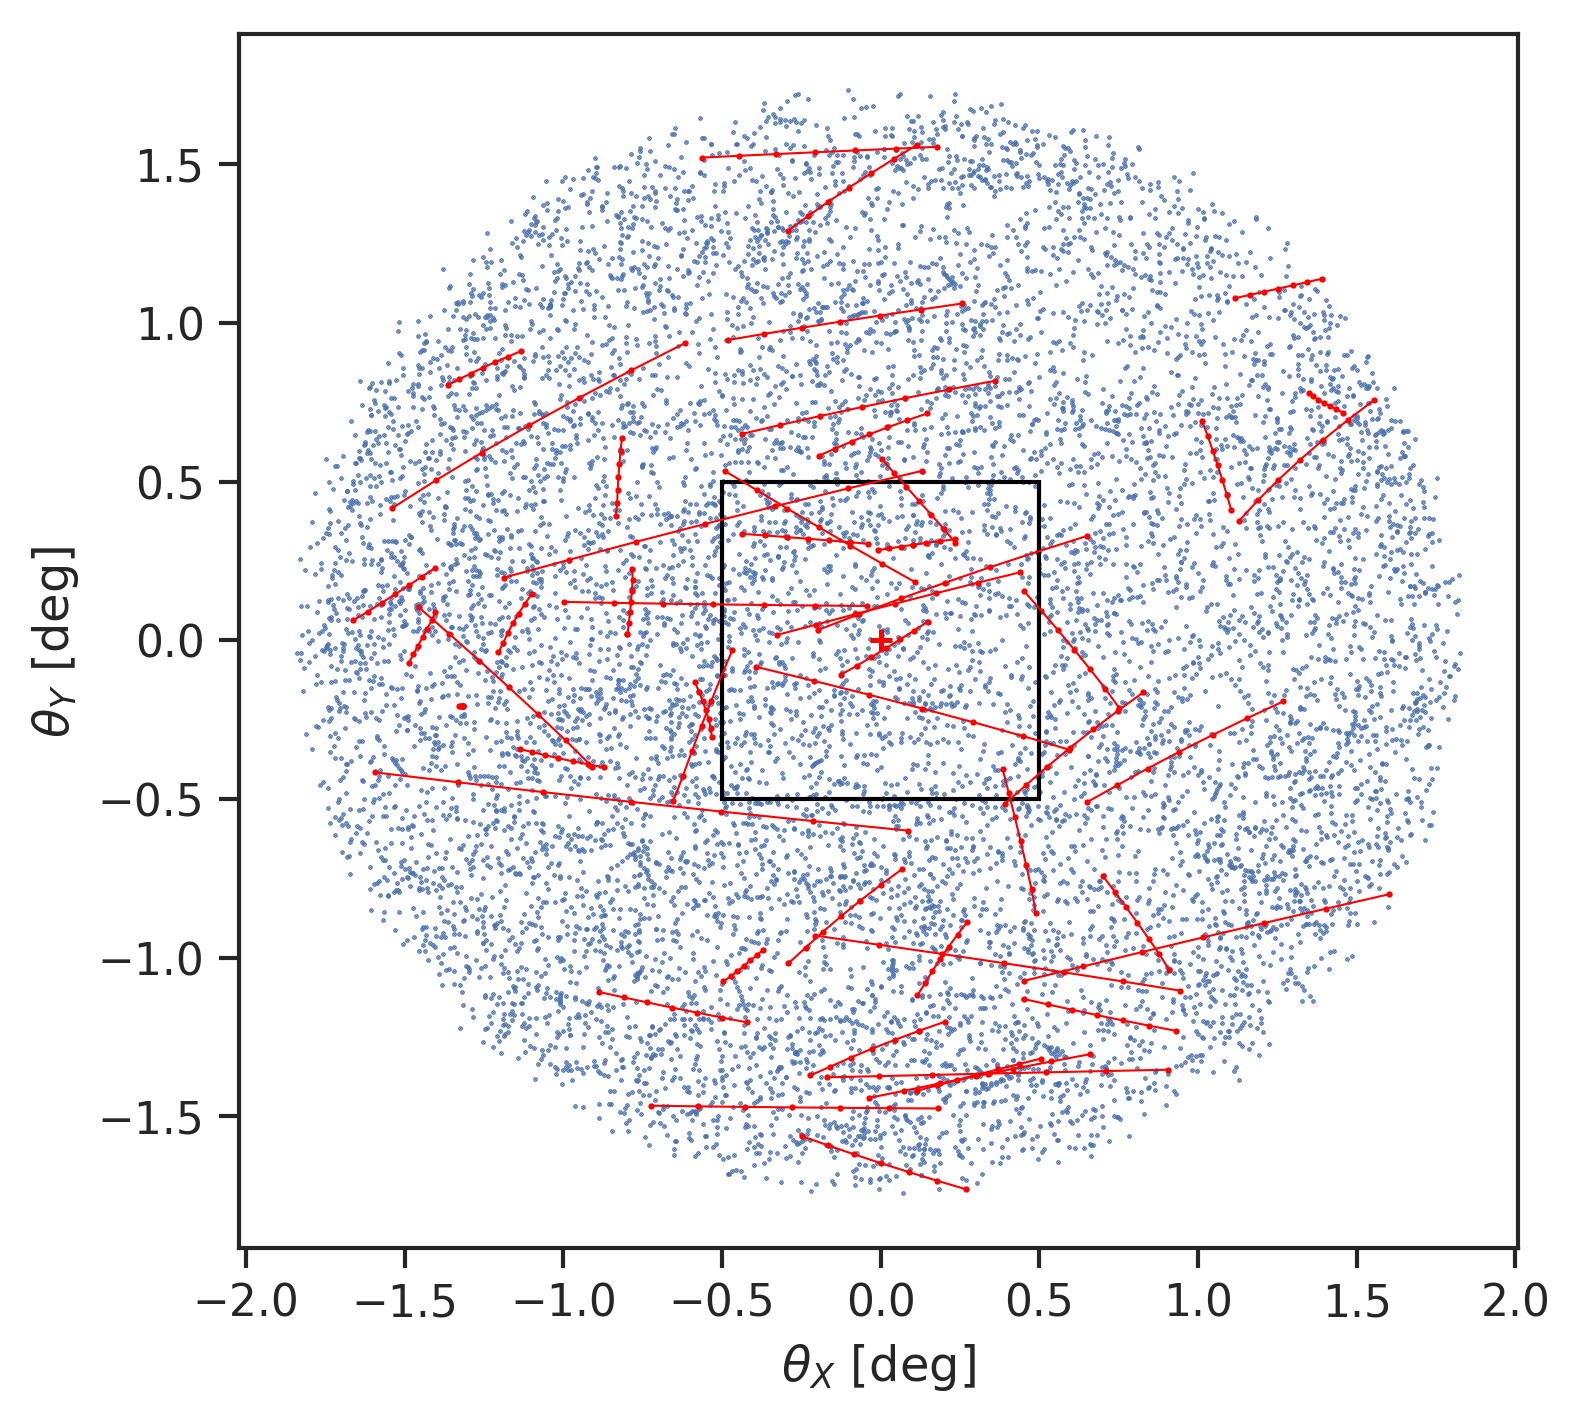

In [21]:
fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(5.5, 5.5))
ax.scatter(*projected_obs[["theta_x_deg", "theta_y_deg"]].values.T, s=0.1, c="b")
for f in findable:
    ax.plot(*projected_obs[projected_obs["designation"].isin([f])][["theta_x_deg", "theta_y_deg"]].values.T, lw=0.5, c="red")
ax.scatter(*projected_obs[projected_obs["designation"].isin(findable)][["theta_x_deg", "theta_y_deg"]].values.T, s=0.5, c="red")
ax.set_xlabel(r"$\theta_X$ [$\deg$]")
ax.set_ylabel(r"$\theta_Y$ [$\deg$]")
ax.set_aspect("equal")
ax.scatter(0, 0, s=30, c="red", marker="+")
ax.add_patch(patches.Rectangle((-0.5, -0.5), 1, 1, fill=False, lw=1, color="black"))
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "algorithm3.{}".format(FORMAT)),
            bbox_inches='tight')

### Hough Transform

In [22]:
small = ((projected_obs["theta_x_deg"] > -0.5) & (projected_obs["theta_x_deg"] < 0.5) &
                          (projected_obs["theta_y_deg"] > -0.5) & (projected_obs["theta_y_deg"] < 0.5))
chosen = ["97142", "W8761", "S8106", "l7272", "U6429", "T1794", "K15T74X", "Q2049", "K03SW8X", "S0525"]

In [23]:
from thor import clusterVelocity

obs_ids = projected_obs["obsId"].values
theta_x = projected_obs["theta_x_deg"].values
theta_y = projected_obs["theta_y_deg"].values
mjd = projected_obs["exp_mjd"].values
truth = observations["designation"].values

first = np.where(mjd == mjd.min())[0]
theta_x0 = theta_x[first]
theta_y0 = theta_y[first]
mjd0 = mjd[first][0]
dt = mjd - mjd0

vx = 0.008
vy = 0.002
xx = theta_x - vx * dt
yy = theta_y - vy * dt

projected_obs["xx"] = xx
projected_obs["yy"] = yy

clusterVelocity(obs_ids, theta_x, theta_y, dt, vx, vy)

[array([ 138681,  462191,  788515, 1117818, 1456786, 1792055, 2130337])]

In [24]:
orbits[orbits["designation"].isin(chosen)]

designation     H     G epoch_pf_TT  meanAnom_deg  argPeri_deg  \
97141        97142  15.0  0.15       K183N     259.31904    322.12438   
262048       Q2049  18.1  0.15       K183N      35.91568    283.42084   
280524       S0525  17.6  0.15       K183N     198.62983    198.85559   
288105       S8106  16.9  0.15       K183N     207.44258    313.18783   
291793       T1794  17.0  0.15       K183N     200.91085    176.81574   
306428       U6429  17.2  0.15       K183N     257.35726    145.78745   
328760       W8761  16.5  0.15       K183N     275.08913    277.65109   
477271       l7272  17.8  0.15       K183N     135.38347    325.73615   
523534     K03SW8X  18.2  0.15       K183N     146.09562    355.54600   
619023     K15T74X  17.6  0.15       K183N     211.24059    323.90297   

        ascNode_deg    i_deg         e  n_deg_p_day  ...  numObs numOppos  \
97141      34.20439  4.90315  0.096050     0.193234  ...   535.0     13.0   
262048    147.05789  2.53321  0.199817     0.277919  ...   107.0      7.0   
280524    135.76358  2.18869  0.202603     0.257484  ...   117.0      9.0   
288105     34.77461  3.96076  0.207056     0.238263  ...   212.0     11.0   
291793    177.69112  7.47670  0.187206     0.236008  ...   211.0      9.0   
306428    174.81330  5.13400  0.262492     0.234420  ...   126.0      8.0   
328760     65.18415  2.96292  0.103041     0.194088  ...   118.0      7.0   
477271     36.22236  5.34436  0.246427     0.273954  ...    71.0      5.0   
523534     37.71170  3.95816  0.209229     0.234860  ...    34.0      5.0   
619023     47.94705  2.43955  0.108848     0.213216  ...    51.0      4.0   

           obsArc  rmsResid_arcsec  coarsePerturbers precisePerturbers  \
97141   1999-2017             0.43               M-v               38h   
262048  2004-2018             0.32               M-v               38h   
280524  2000-2016             0.43               M-v               38h   
288105  2003-2018             0.39               M-v               38h   
291793  2003-2018             0.40               M-v               38h   
306428  1998-2018             0.32               M-v               38h   
328760  2004-2017             0.30               M-v               38h   
477271  2009-2016             0.36               M-v               38h   
523534  2003-2013             0.25               M-v               38h   
619023  2010-2017             0.25               M-v               38h   

        compName flags  readableDesignation lastObsInOrbitSolution  
97141   MPCLINUX  0000   (97142) 1999 VJ141             20170501.0  
262048  MPCLINUX  0000  (262049) 2006 QU182             20180211.0  
280524  MPCLINUX  0000  (280525) 2004 PD108             20161204.0  
288105  MPCLINUX  0000   (288106) 2003 WP46             20180318.0  
291793  MPCLINUX  0000   (291794) 2006 KG64             20180320.0  
306428  MPCLINUX  0000   (306429) 1998 ST45             20180318.0  
328760  MPCLINUX  0000   (328761) 2009 UN94             20170416.0  
477271  MPCLINUX  0000  (477272) 2009 SJ110             20160827.0  
523534    MPCADO  0000           2003 SX328             20130116.0  
619023  MPCLINUX  0000            2015 TX74             20170222.0  

[10 rows x 23 columns]

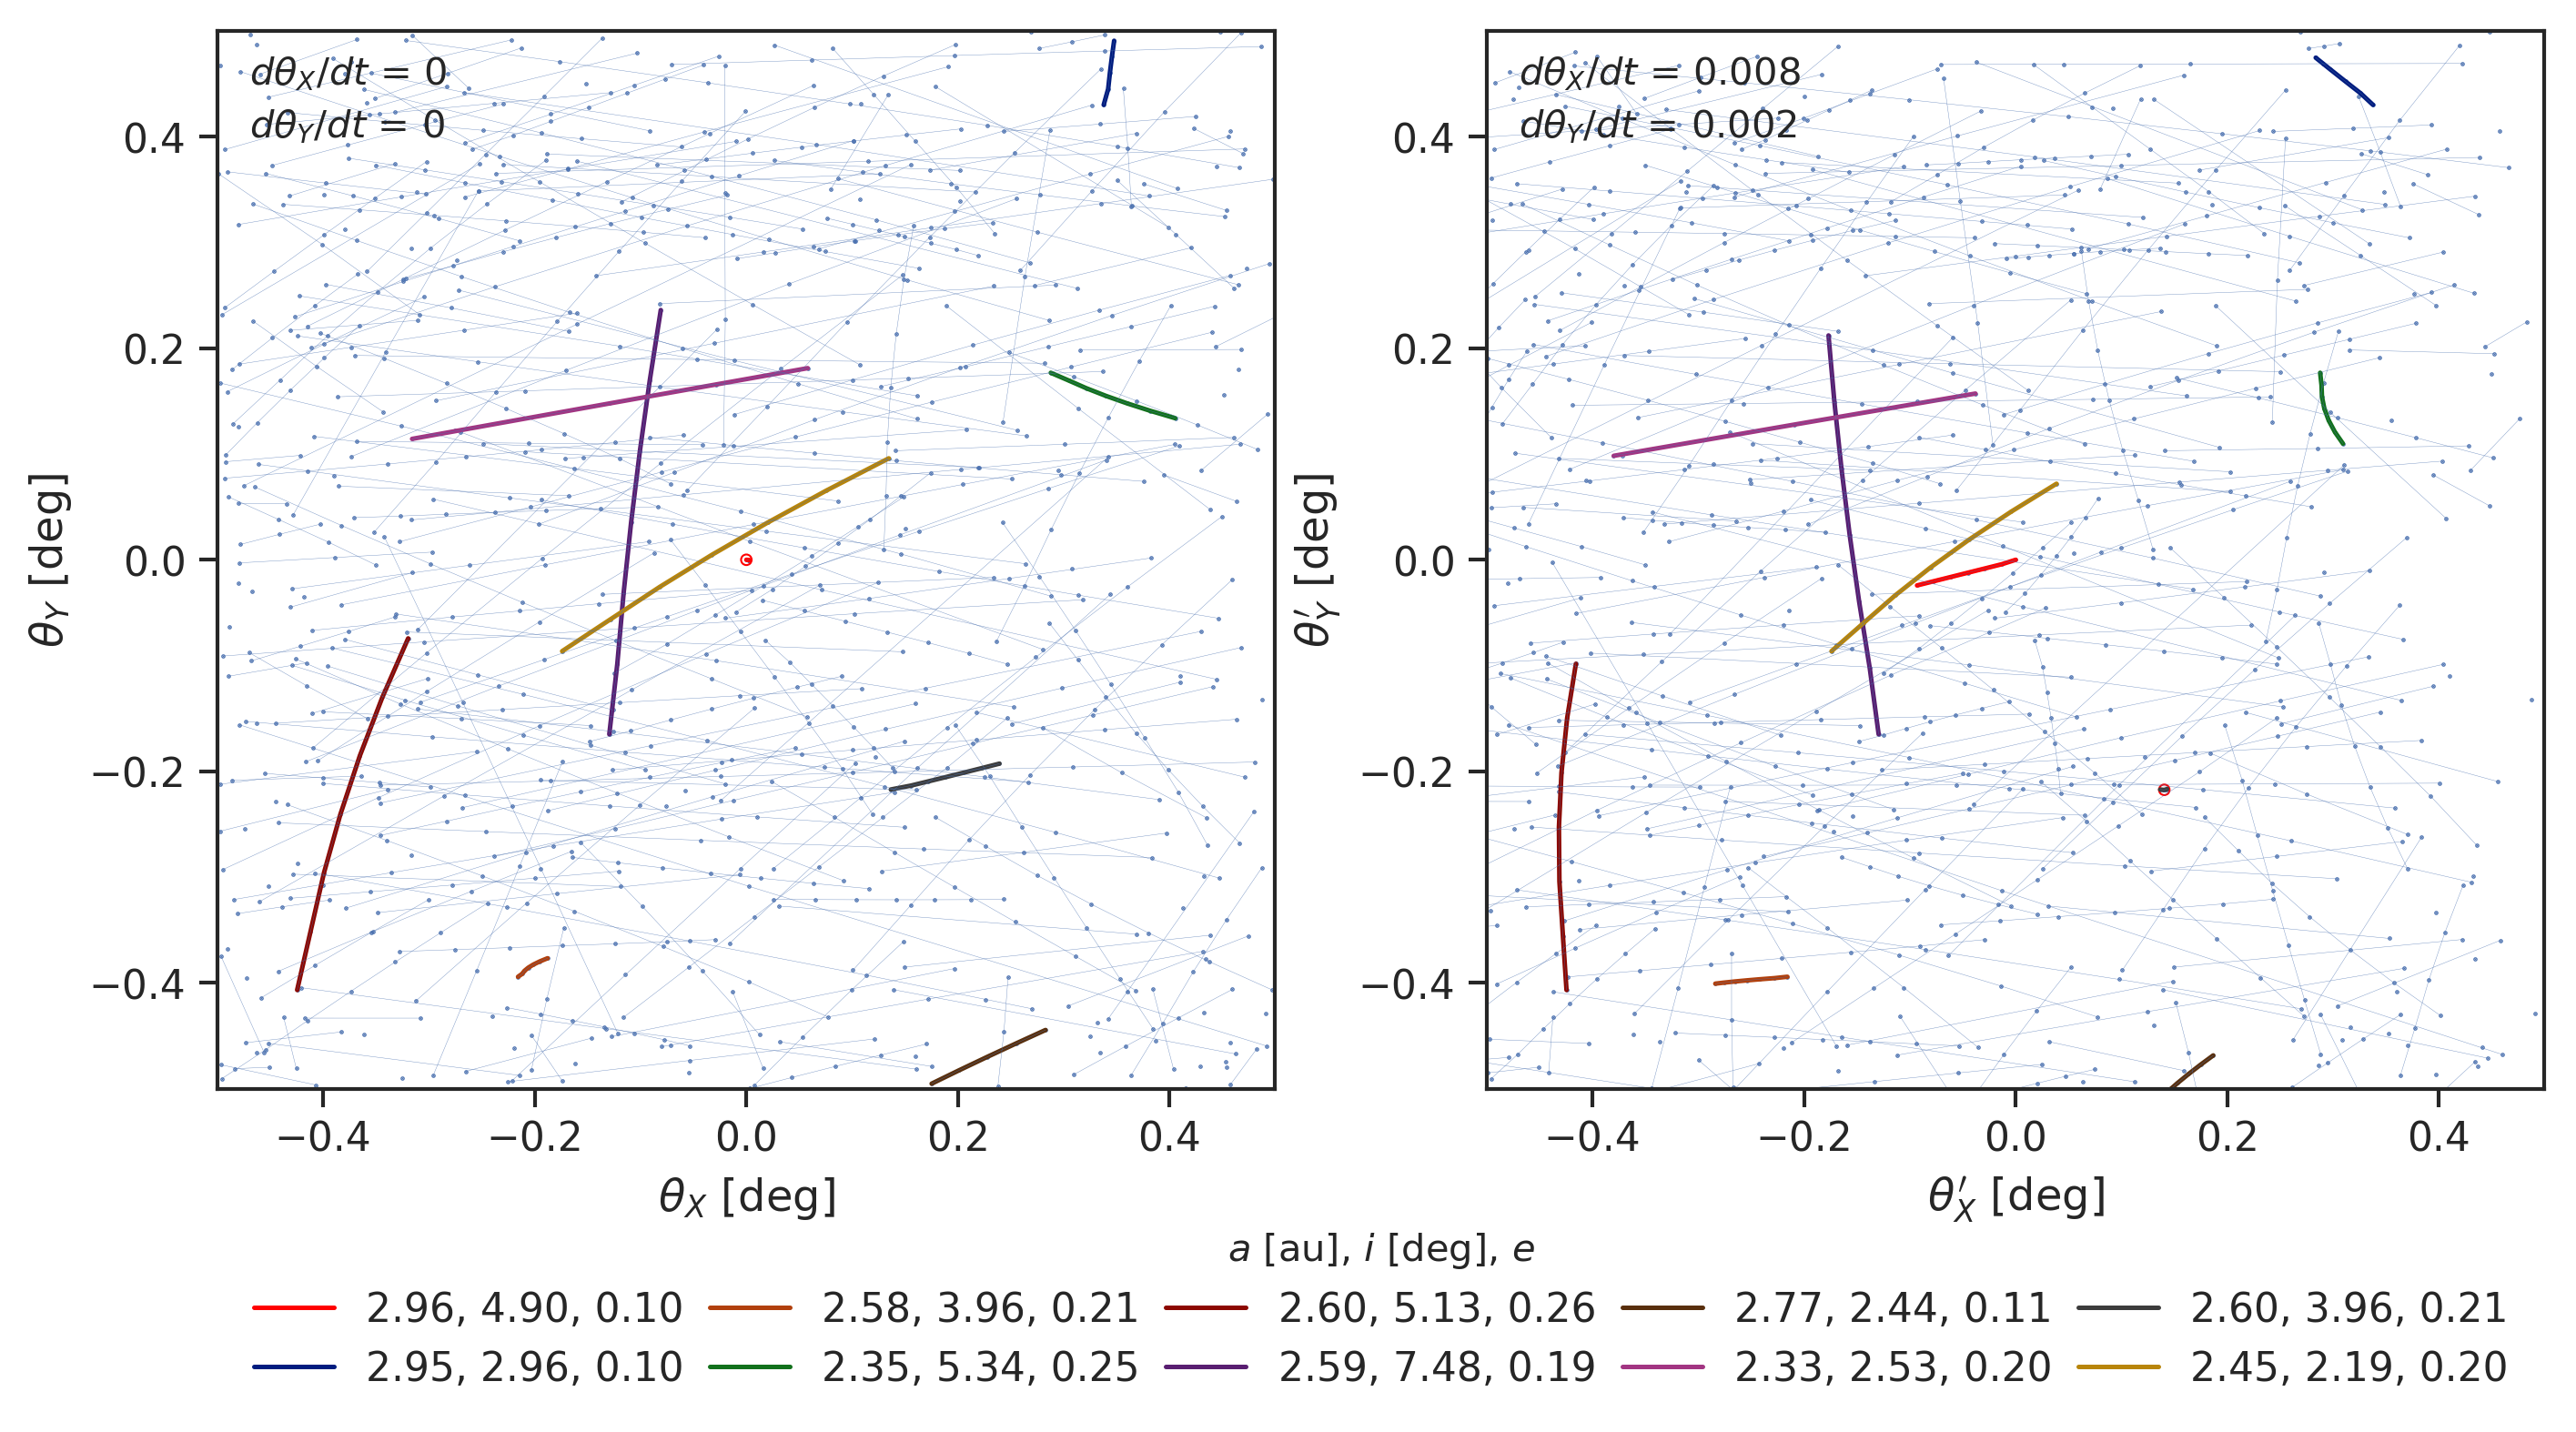

In [25]:
fig, ax = plt.subplots(1, 2, dpi=DPI, figsize=(11, 5.5))

ax[0].scatter(*projected_obs[small][["theta_x_deg", "theta_y_deg"]].values.T, s=0.1, c="b")

for c, designation in zip(['red'] + sns.color_palette("dark").as_hex(), chosen):
    ax[0].plot(*projected_obs[small & (projected_obs["designation"] == designation)][["theta_x_deg", "theta_y_deg"]].values.T,
           color=c)
    
for designation in projected_obs[(projected_obs["designation"].isin(allObjects_projection[allObjects_projection["findable"] == 1]["designation"].values)) 
               & small]["designation"].unique():
    ax[0].plot(*projected_obs[small & (projected_obs["designation"] == designation)][["theta_x_deg", "theta_y_deg"]].values.T, lw=0.1, color="b", alpha=0.8)

ax[0].set_xlabel(r"$\theta_X$ [$\deg$]")
ax[0].set_ylabel(r"$\theta_Y$ [$\deg$]")
ax[0].set_aspect("equal")
ax[0].add_patch(patches.Circle((0, 0), 0.005, fill=False, lw=0.5, color="red"))
ax[0].set_xlim(-0.5, 0.5)
ax[0].set_ylim(-0.5, 0.5)
ax[0].text(-0.47, 0.45, r"$d\theta_X/dt$ = 0")
ax[0].text(-0.47, 0.4, r"$d\theta_Y/dt$ = 0")


ax[1].scatter(*projected_obs[small][["xx", "yy"]].values.T, s=0.1, c="b")

for c, designation in zip(['red'] + sns.color_palette("dark").as_hex(), chosen):
                  
    ax[1].plot(*projected_obs[small & (projected_obs["designation"] == designation)][["xx", "yy"]].values.T,
           color=c, label="{:.2f}, {:.2f}, {:.2f}".format(*orbits[orbits["designation"] == designation][["a_au", "i_deg", "e"]].values[0]))
    
for designation in projected_obs[(projected_obs["designation"].isin(allObjects_projection[allObjects_projection["findable"] == 1]["designation"].values)) 
               & small]["designation"].unique():
    ax[1].plot(*projected_obs[small & (projected_obs["designation"] == designation)][["xx", "yy"]].values.T, lw=0.1, color="b", alpha=0.8)
    
ax[1].set_xlabel(r"$\theta_X'$ [$\deg$]")
ax[1].set_ylabel(r"$\theta_Y'$ [$\deg$]")
ax[1].set_aspect("equal")
ax[1].add_patch(patches.Circle((0.140453, -0.217489), 0.005, fill=False, lw=0.5, color="red"))

ax[1].set_xlim(-0.5, 0.5)
ax[1].set_ylim(-0.5, 0.5)
ax[1].text(-0.47, 0.45, r"$d\theta_X/dt$ = {}".format(vx))
ax[1].text(-0.47, 0.4, r"$d\theta_Y/dt$ = {}".format(vy))
ax[1].legend(bbox_to_anchor=(-1.2, -0.4, 2.2, 0.3), 
             title="$a$ [au], $i$ [$\deg$], $e$", 
             ncol=5, 
             mode="expand",
             frameon=False)
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "algorithm4.{}".format(FORMAT)),
            bbox_inches='tight')


### Co-rotating Frame Velocities

In [26]:
average_object = thor.findAverageOrbits(observations, orbits[orbits["designation"] == "18043"])

THOR: findAverageObject
-------------------------
Finding average orbit...
Done.
-------------------------



In [27]:
try:
    allObjects_projection_500 = pd.read_csv("allObjects_projection_500.txt", sep=" ", index_col=False)

except:
    projected_obs_500 = thor.rangeAndShift(observations[no_noise], 
                                   average_object[start_epoch]["RA_deg"].values[0],
                                   average_object[start_epoch]["Dec_deg"].values[0],
                                   average_object[start_epoch]["r_au"].values[0],
                                   average_object[start_epoch][["HEclObj_dX/dt_au_p_day",
                                                                "HEclObj_dY/dt_au_p_day",
                                                                "HEclObj_dZ/dt_au_p_day"]].values[0],
                                   average_object[start_epoch]["exp_mjd"].values[0],
                                   cellArea=500,
                                   cellShape="circle",
                                   verbose=False)

    allObjects_projection_500, summary_projection_500 = thor.analyzeProjections(projected_obs_500)
    allObjects_projection_500.to_csv("allObjects_projection_500.txt", sep=" ", index=False)

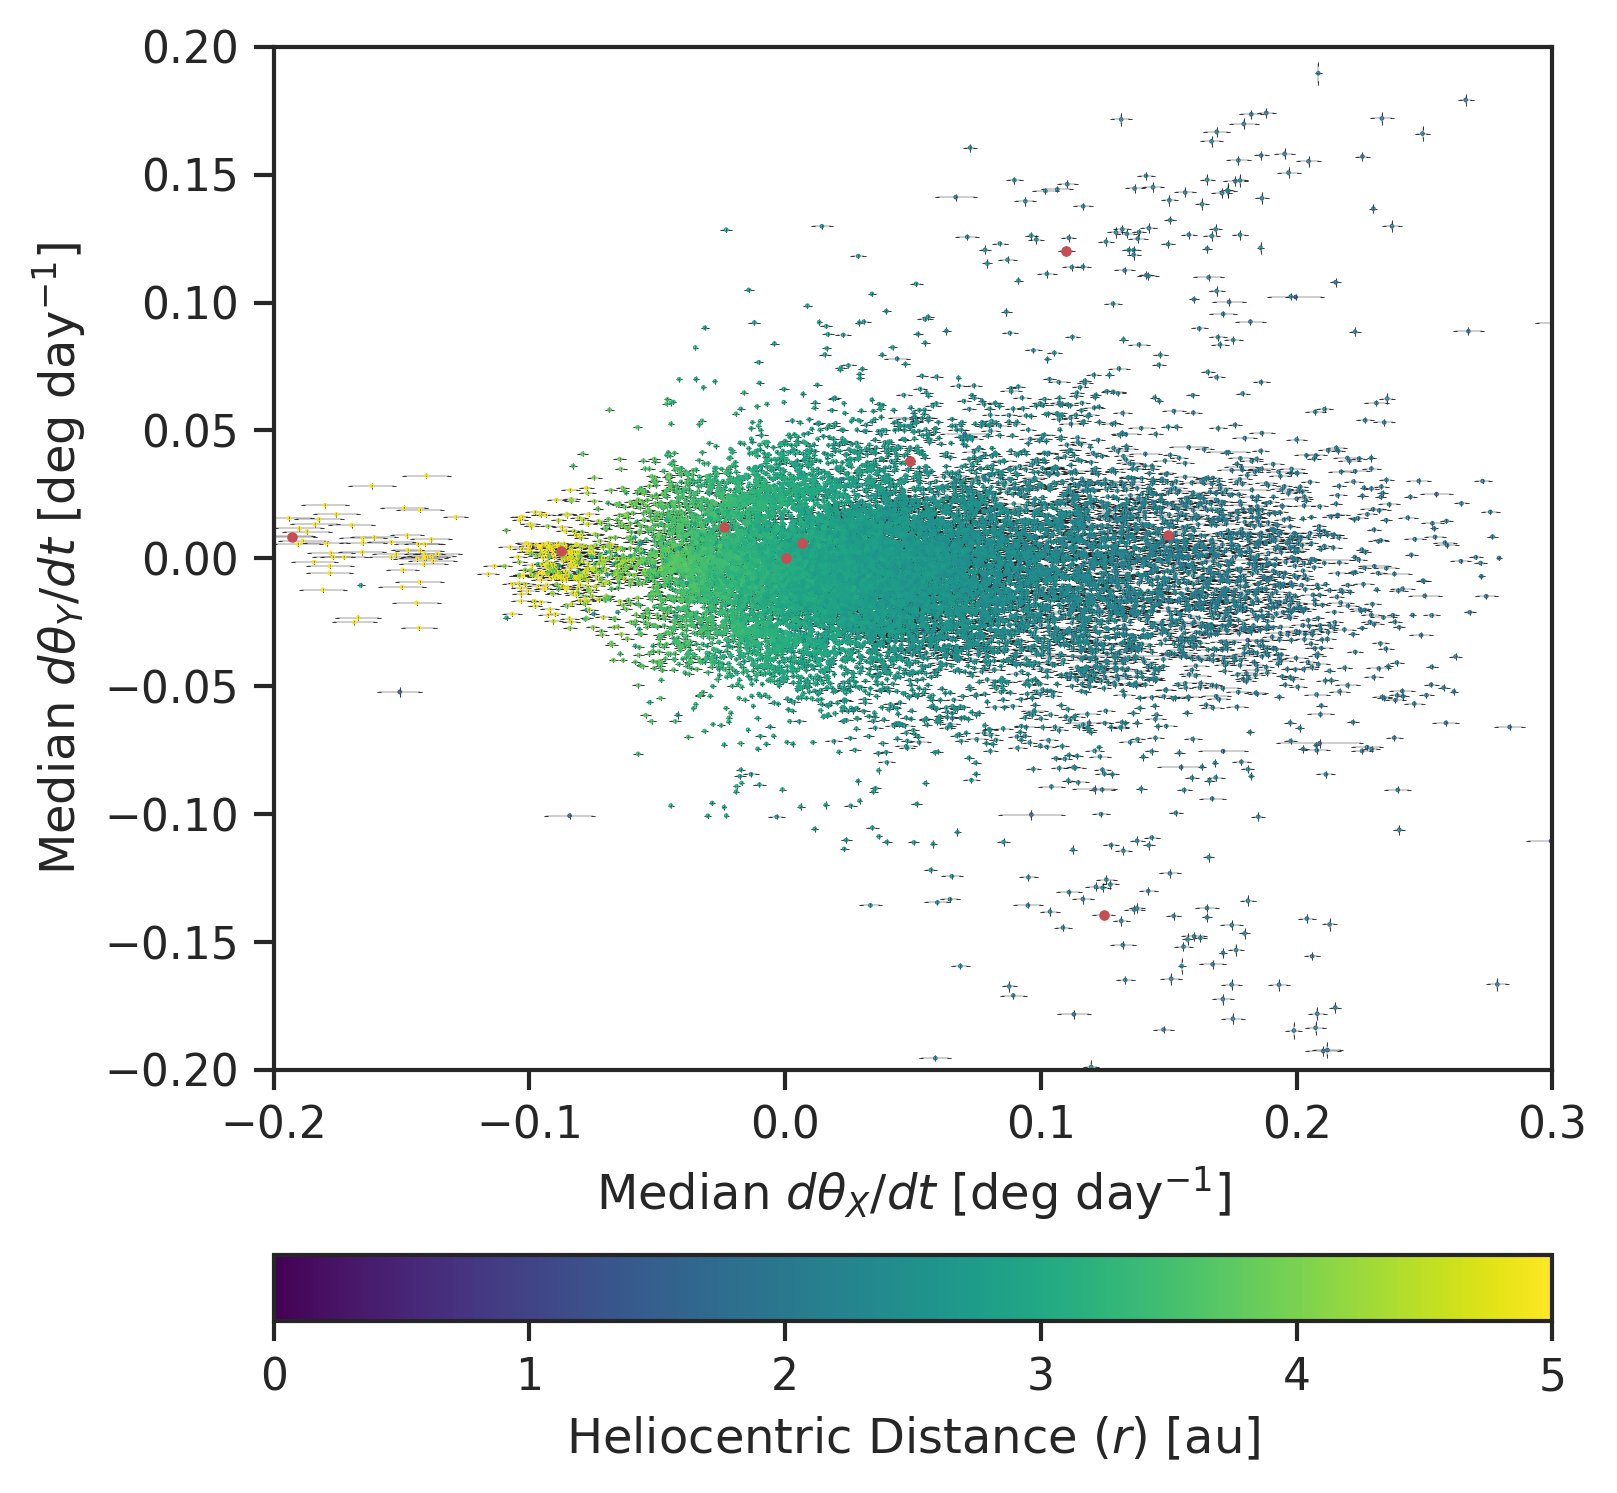

In [28]:
fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(5.5, 5.5))
ax.errorbar(allObjects_projection_500[(allObjects_projection_500["findable"] == 1)]["dtheta_x/dt_median"].values,
            allObjects_projection_500[(allObjects_projection_500["findable"] == 1)]["dtheta_y/dt_median"].values,
            yerr=allObjects_projection_500[(allObjects_projection_500["findable"] == 1)]["dtheta_y/dt_sigma"].values,
            xerr=allObjects_projection_500[(allObjects_projection_500["findable"] == 1)]["dtheta_x/dt_sigma"].values,
            fmt="o",
            ms=0.01,
            capsize=0.1,
            elinewidth=0.1,
            c="k", zorder=-1)
cm = ax.scatter(allObjects_projection_500[(allObjects_projection_500["findable"] == 1)]["dtheta_x/dt_median"].values, 
                allObjects_projection_500[(allObjects_projection_500["findable"] == 1)]["dtheta_y/dt_median"].values,
                s=0.1,
                c=allObjects_projection_500[(allObjects_projection_500["findable"] == 1)]["r_au_median"].values,
                vmin=0,
                vmax=5.0,
                cmap="viridis")
ax.set_aspect("equal")
ax.scatter(allObjects_projection_500[(allObjects_projection_500["designation"].isin(test_orbits))]["dtheta_x/dt_median"].values, 
           allObjects_projection_500[(allObjects_projection_500["designation"].isin(test_orbits))]["dtheta_y/dt_median"].values,
           s=3,
           c="r")

cbar_ax = fig.add_axes([0.125, 0.04, 0.775, 0.04])
fig.colorbar(cm, 
             cax=cbar_ax, 
             label=r"Heliocentric Distance ($r$) [au]", 
             #format="%1i", 
             orientation="horizontal")

# Add labels and text
cbar_ax.set_label("r [au]")
ax.set_xlabel(r"Median $d\theta_X / dt$ [$\deg$ $\mathrm{day}^{-1}$]")
ax.set_ylabel(r"Median $d\theta_Y / dt$ [$\deg$ $\mathrm{day}^{-1}$]")
ax.set_xlim(-0.2, 0.3)
ax.set_ylim(-0.2, 0.2)
ax.set_aspect("equal")
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "orbit_frame_velocity_500.{}".format(FORMAT)),
            bbox_inches='tight')

### Completeness

In [29]:
from thor import Config

def plotCompleteness(allObjects, orbits, testOrbits=None, columnMapping=Config.columnMapping, testOrbitScatterKwargs={"s": 2, "c": "red"}):
    
    findable = allObjects[allObjects["findable"] == 1]["designation"].values
    found = allObjects[allObjects["found"] == 1]["designation"].values
    missed = allObjects[(allObjects["found"] == 0) & (allObjects_survey["findable"] == 1)]["designation"].values

    BINS = 50
    RANGE_AI = [[0.5, 5.5], [0, 50]]
    RANGE_AE = [RANGE_AI[0], [0, 1]]
    LEVELS = [10, 100, 1000]

    # Calculate 2D binned statistics:
    # X_ai: orbital distribution in a and i
    # N_ai : number of objects discoverable in same bins as X_ai
    X_ai = binned_statistic_2d(
        orbits[orbits["designation"].isin(found)]["a_au"].values,
        orbits[orbits["designation"].isin(found)]["i_deg"].values,
        orbits[orbits["designation"].isin(found)]["e"].values,    
        statistic="count",
        range=RANGE_AI,
        bins=BINS)

    N_ai = binned_statistic_2d(
        orbits[orbits["designation"].isin(findable)]["a_au"].values,
        orbits[orbits["designation"].isin(findable)]["i_deg"].values,
        orbits[orbits["designation"].isin(findable)]["e"].values,    
        statistic="count",
        range=RANGE_AI,
        bins=BINS)
    
    stat_ai = X_ai.statistic.T / N_ai.statistic.T * 100.0
    counts_ai = N_ai.statistic.T
    stat_ai=np.ma.masked_where(stat_ai==np.NaN, stat_ai)
    
    # Calculate 2D binned statistics:
    # X_ae: orbital distribution in a and e
    # N_ae : number of objects discoverable in same bins as X_ai
    X_ae = binned_statistic_2d(
        orbits[orbits["designation"].isin(found)]["a_au"].values,
        orbits[orbits["designation"].isin(found)]["e"].values,
        orbits[orbits["designation"].isin(found)]["i_deg"].values,    
        statistic="count",
        range=RANGE_AE,
        bins=BINS)

    N_ae = binned_statistic_2d(
        orbits[orbits["designation"].isin(findable)]["a_au"].values,
        orbits[orbits["designation"].isin(findable)]["e"].values,
        orbits[orbits["designation"].isin(findable)]["i_deg"].values,    
        statistic="count",
        range=RANGE_AE,
        bins=BINS)

    stat_ae = X_ae.statistic.T / N_ae.statistic.T * 100.0
    counts_ae = N_ae.statistic.T
    stat_ae=np.ma.masked_where(stat_ae==np.NaN, stat_ae)
    
    # Make the figure
    fig, ax = plt.subplots(2, 1, dpi=DPI, figsize=(5.5, 9))
    fig.subplots_adjust(
        # the left side of the subplots of the figure
        left=0.15,  
        # the right side of the subplots of the figure
        right=1.0,
        # the bottom of the subplots of the figure
        bottom=0.2,
        # the top of the subplots of the figure
        top=0.95,
        # the amount of width reserved for space between subplots,
        # expressed as a fraction of the average axis width
        wspace=0.01,   
        # the amount of height reserved for space between subplots,
        # expressed as a fraction of the average axis height
        hspace=0.2)   
                       
    
    # Set NaN values in stat to be white 
    cmap = matplotlib.cm.viridis
    cmap.set_bad('w', np.NaN)

    # Plot a-i completeness
    cm1 = ax[0].imshow(stat_ai, 
                   origin="lower", 
                   cmap=cmap,
                   interpolation='none',
                   aspect="auto",
                   extent=[X_ai.x_edge[0], X_ai.x_edge[-1], X_ai.y_edge[0], X_ai.y_edge[-1]])

    # Add contours
    cs1 = ax[0].contour(counts_ai, 
                    LEVELS, 
                    origin="lower", 
                    extent=[N_ai.x_edge[0], N_ai.x_edge[-1], N_ai.y_edge[0], N_ai.y_edge[-1]],
                    colors="red",
                    linewidths=1)
    plt.clabel(cs1, inline=1, fontsize=4, fmt="%1.0f")

    # Add labels
    ax[0].set_ylabel("Inclination ($i$) [$\deg$]")
    ax[0].set_xlabel("Semi-Major Axis ($a$) [au]")
    ax[0].set_xlim(*RANGE_AI[0])
    ax[0].set_ylim(*RANGE_AI[1])

    # Plot a-e completeness
    cm2 = ax[1].imshow(stat_ae, 
                   origin="lower", 
                   cmap=cmap,
                   interpolation='none',
                   aspect="auto",
                   #norm=colors.LogNorm(),
                   extent=[X_ae.x_edge[0], X_ae.x_edge[-1], X_ae.y_edge[0], X_ae.y_edge[-1]])
    
    # Plot test orbits 
    if type(testOrbits) == pd.DataFrame:
        # If test orbits exist in known orbits, plot them
        test_orbits_in_known = orbits[orbits[columnMapping["name"]].isin(testOrbits[columnMapping["name"]].values)]
        if len(test_orbits_in_known) != 0:
            ax[0].scatter(*test_orbits_in_known[[columnMapping["a_au"], columnMapping["i_deg"]]].values.T, 
                       label="Test Orbits",
                       zorder=10,
                       **testOrbitScatterKwargs)
            
            ax[1].scatter(*test_orbits_in_known[[columnMapping["a_au"], columnMapping["e"]]].values.T, 
                       label="Test Orbits",
                       zorder=10,
                       **testOrbitScatterKwargs)

    # Add contours
    cs2 = ax[1].contour(counts_ae, 
                    LEVELS, 
                    origin="lower", 
                    extent=[N_ae.x_edge[0], N_ae.x_edge[-1], N_ae.y_edge[0], N_ae.y_edge[-1]],
                    colors="red",
                    linewidths=1)
    plt.clabel(cs2, inline=1, fontsize=4, fmt="%1.0f")

    # Add labels
    ax[1].set_ylabel("Eccentricity ($e$)")
    ax[1].set_xlabel("Semi-Major Axis ($a$) [au]")
    ax[1].set_xlim(*RANGE_AE[0])
    ax[1].set_ylim(*RANGE_AE[1])
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.15, 0.1, 0.65, 0.02])
    fig.colorbar(cm2, 
                 cax=cbar_ax, 
                 label="Completeness [%]", 
                 format="%1i", 
                 orientation="horizontal")
     
    return fig, ax 

/epyc/projects/thor/envs/thor_py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning:

invalid value encountered in true_divide

/epyc/projects/thor/envs/thor_py36/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning:

invalid value encountered in true_divide



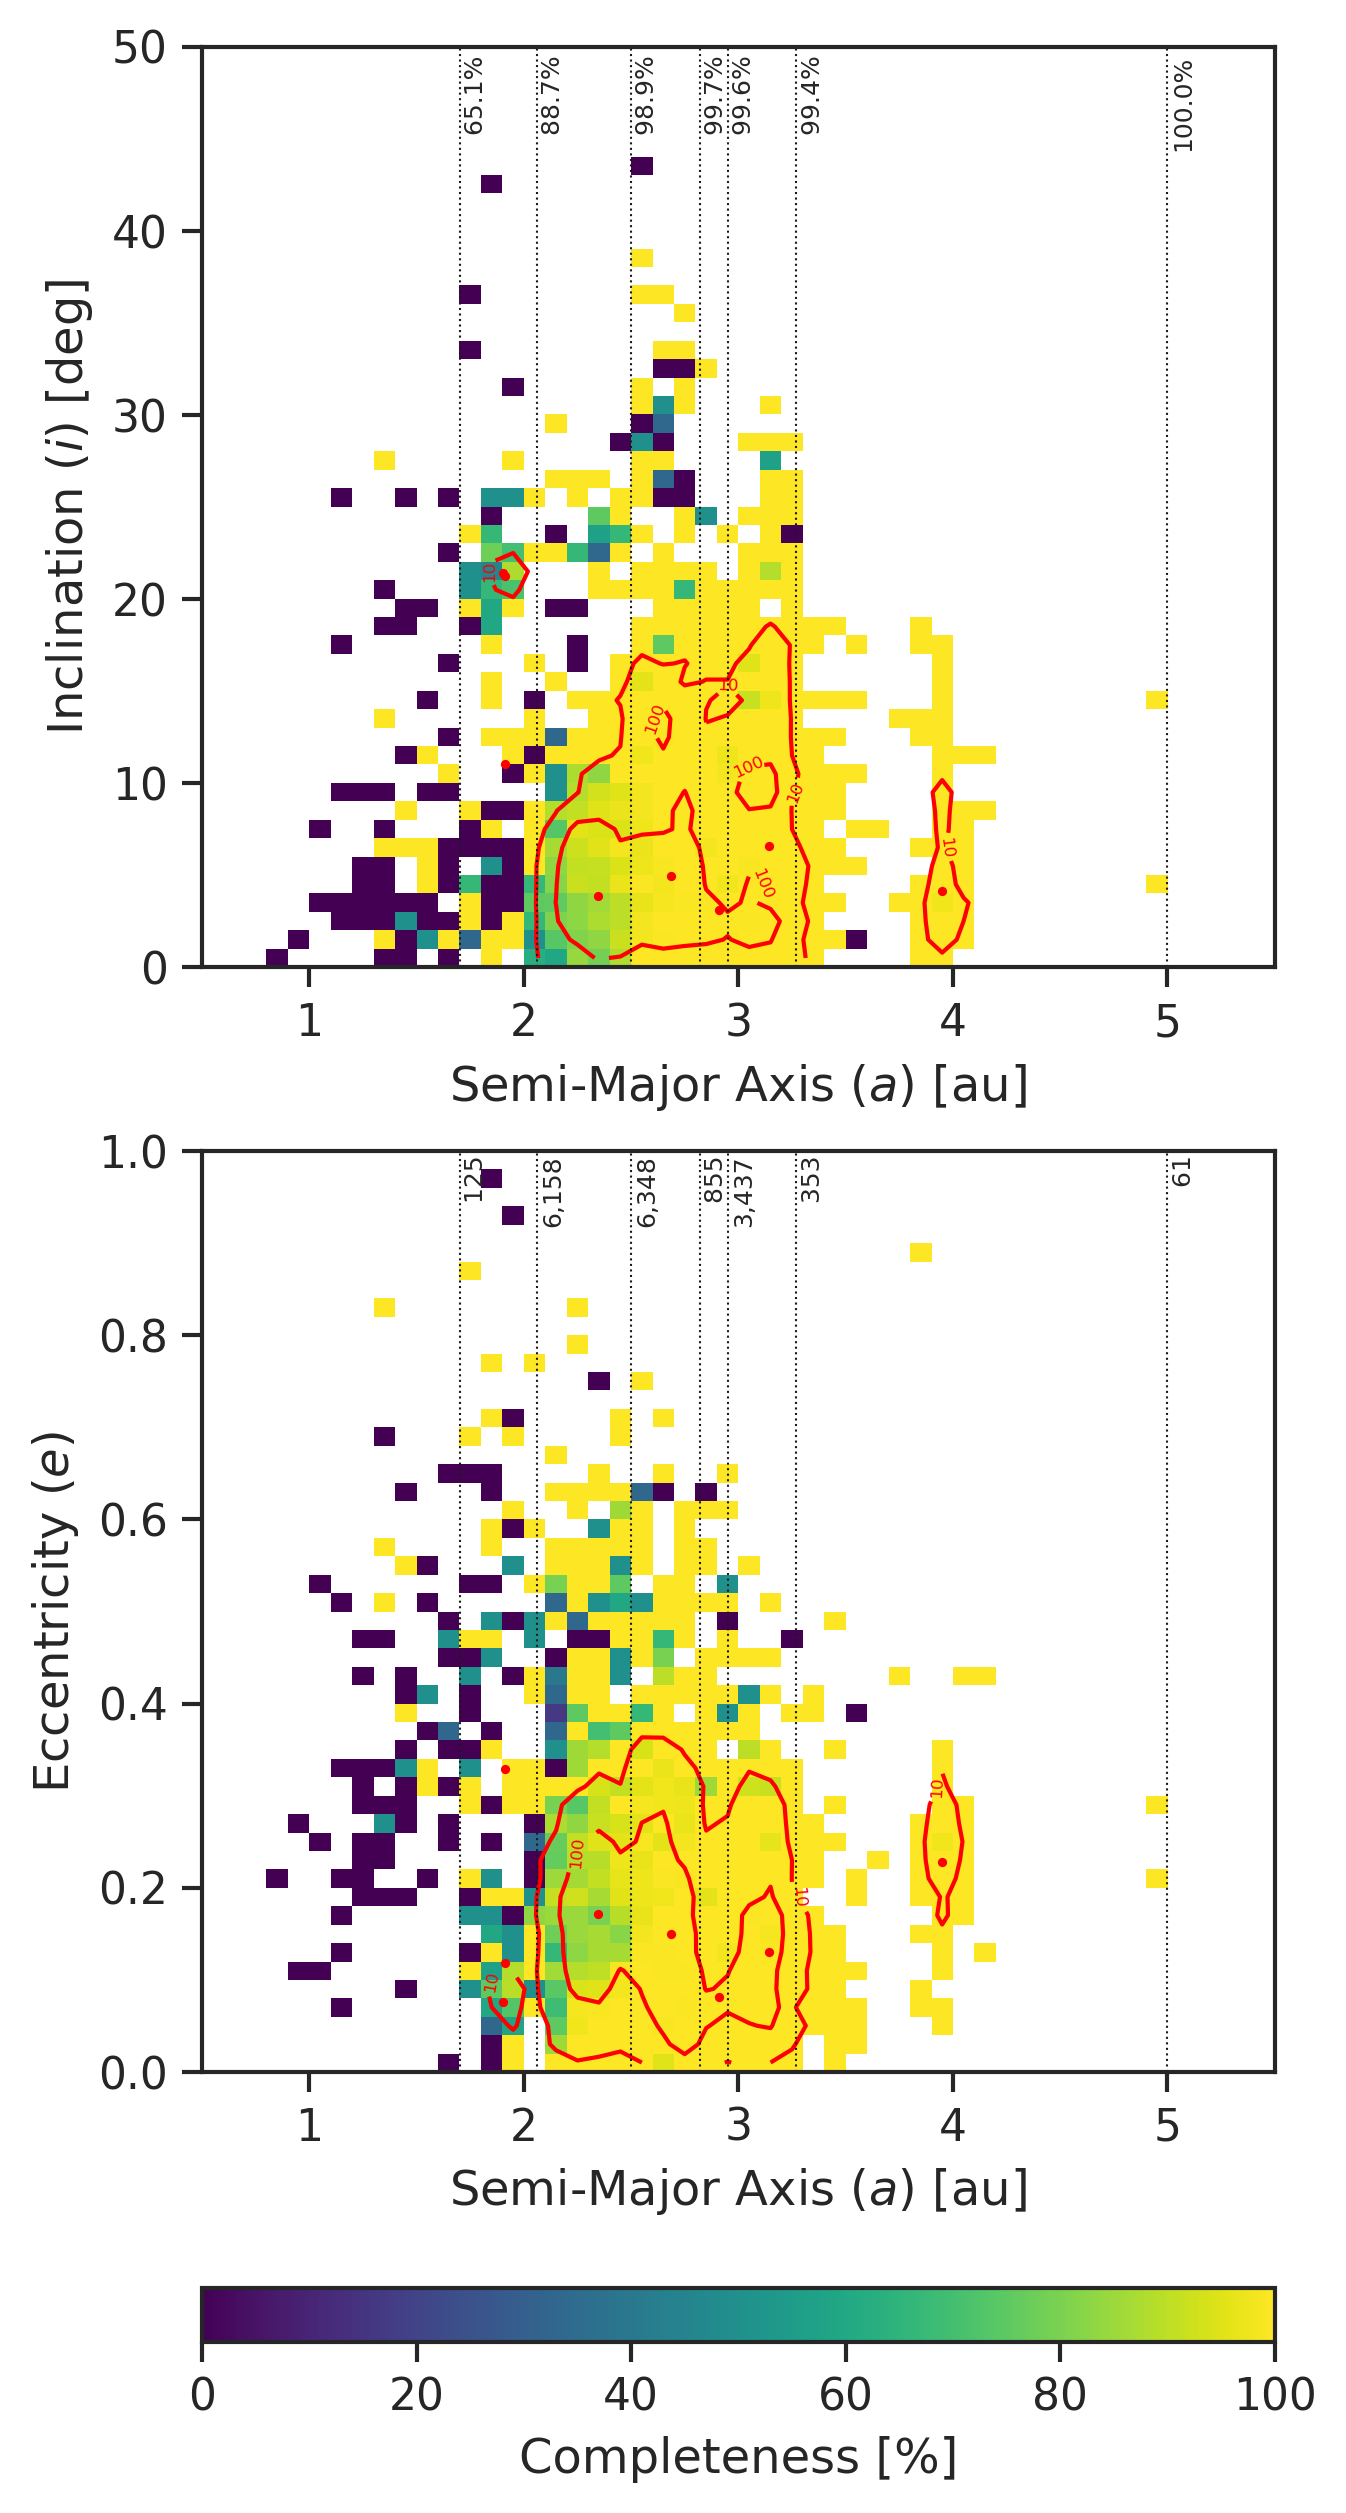

In [30]:
fig, ax = plotCompleteness(allObjects_survey, 
                 known_orbits, 
                 testOrbits=known_orbits[known_orbits["designation"].isin(test_orbits)])
ax[0].vlines([1.7, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0], 0, 50, lw=0.5, linestyle=":")
ax[1].vlines([1.7, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0], 0, 50, lw=0.5, linestyle=":")
ax[0].text(1.72, 48.5, " 65.1%", fontsize=6, rotation='vertical')
ax[0].text(2.08, 48.5, " 88.7%", fontsize=6, rotation='vertical')
ax[0].text(2.52, 48.5, " 98.9%", fontsize=6, rotation='vertical')
ax[0].text(2.84, 48.5, " 99.7%", fontsize=6, rotation='vertical')
ax[0].text(2.97, 48.5, " 99.6%", fontsize=6, rotation='vertical')
ax[0].text(3.29, 48.5, " 99.4%", fontsize=6, rotation='vertical')
ax[0].text(5.02, 48.5, "100.0%", fontsize=6, rotation='vertical')

ax[1].text(1.72, 0.975, "  125", fontsize=6, rotation='vertical')
ax[1].text(2.08, 0.975, "6,158", fontsize=6, rotation='vertical')
ax[1].text(2.52, 0.975, "6,348", fontsize=6, rotation='vertical')
ax[1].text(2.84, 0.975, "  855", fontsize=6, rotation='vertical')
ax[1].text(2.97, 0.975, "3,437", fontsize=6, rotation='vertical')
ax[1].text(3.29, 0.975, "  353", fontsize=6, rotation='vertical')
ax[1].text(5.02, 0.975, "   61", fontsize=6, rotation='vertical')



if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "simulations_a_ie_completeness.{}".format(FORMAT)),
            bbox_inches='tight')

### Non-linear Velocities

In [31]:
allClusters_projection = []
allObjects_projection = []
for i in range(9):
    allClusters_projection.append(pd.read_csv(os.path.join(RUN_DIR, "orbit_000{}/allClusters.txt".format(i + 1)), sep=" ", index_col=False))
    allObjects_projection.append(pd.read_csv(os.path.join(RUN_DIR, "orbit_000{}/allObjects.txt".format(i + 1)), sep=" ", index_col=False))
    
allClusters_projection = pd.concat(allClusters_projection)
allObjects_projection = pd.concat(allObjects_projection)

In [32]:
found = allObjects_projection[allObjects_projection["found"] == 1]
findable = allObjects_projection[allObjects_projection["findable"] == 1]
missed = allObjects_projection[(allObjects_projection["findable"] == 1) & (allObjects_projection["found"] == 0)]

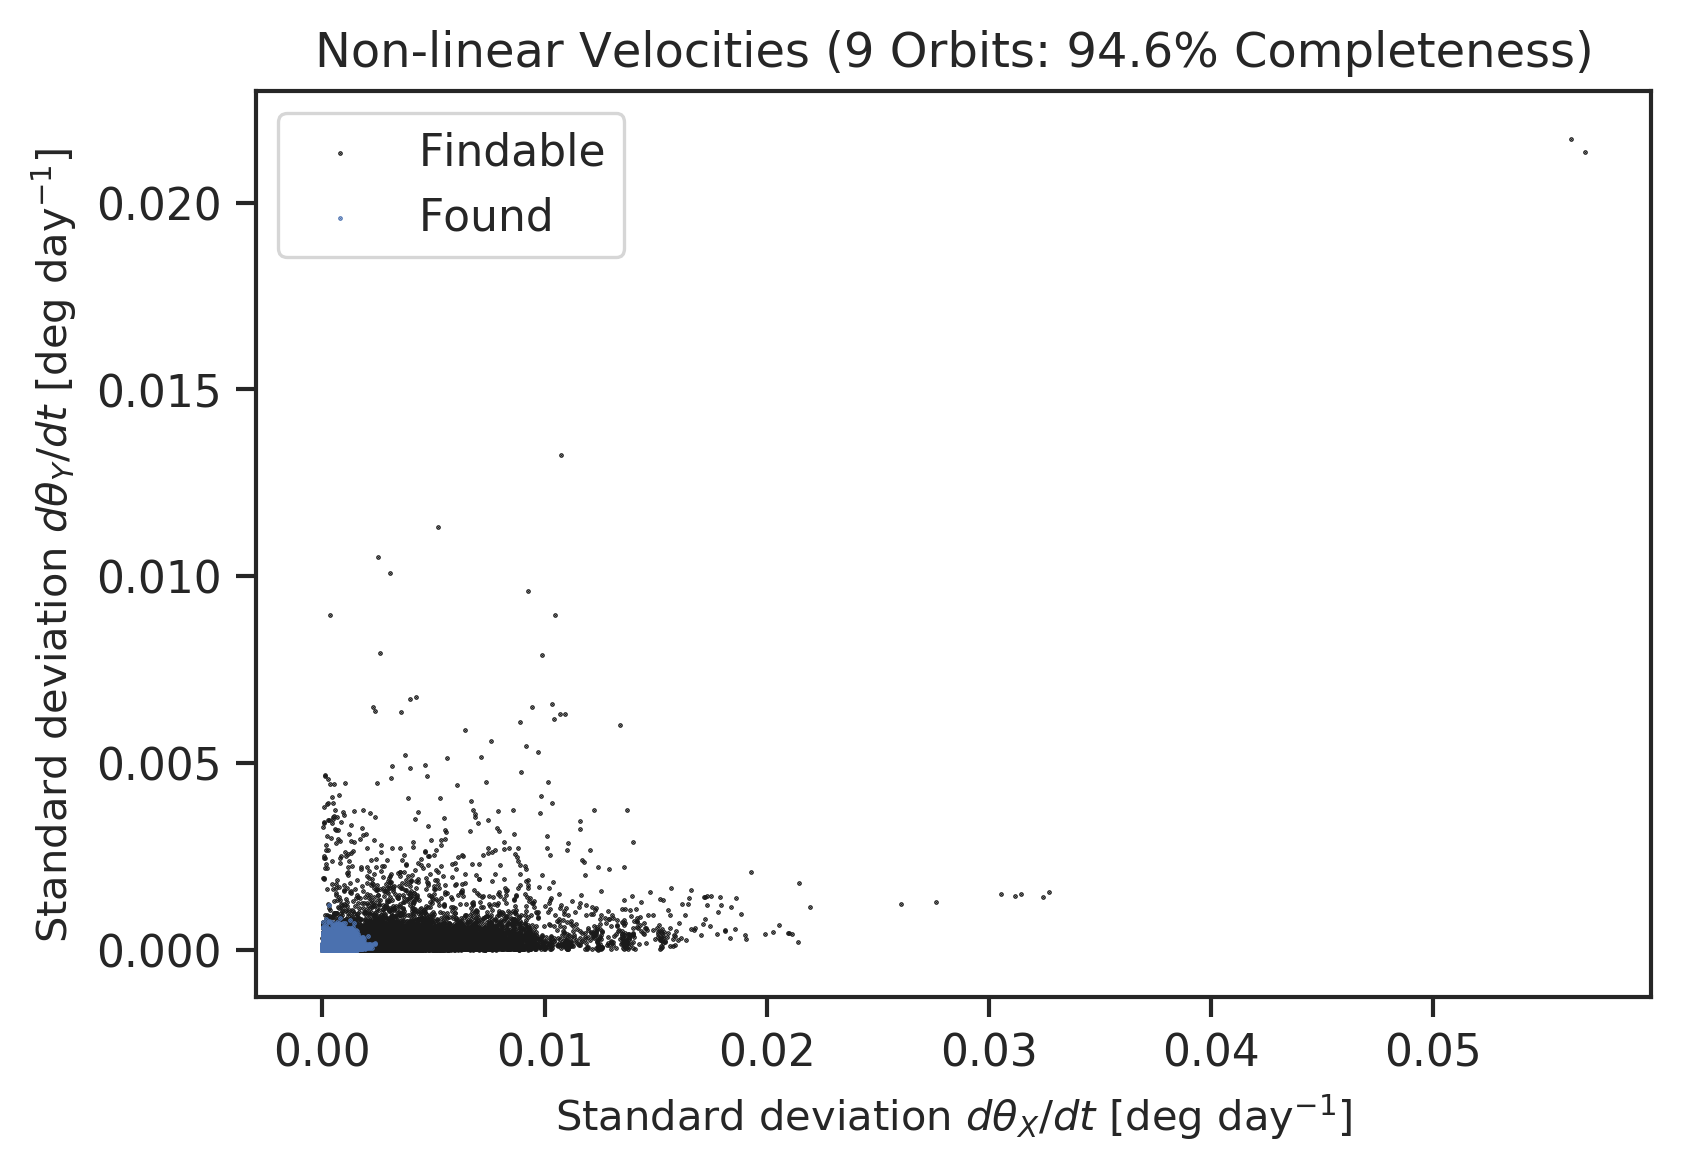

In [36]:
fig, ax = plt.subplots(1, 1, dpi=DPI)
ax.set_title("Non-linear Velocities (9 Orbits: 94.6% Completeness)")
ax.scatter(*findable[["dtheta_x/dt_sigma", "dtheta_y/dt_sigma"]].values.T, s=0.1, c="k", label="Findable")
ax.scatter(*found[["dtheta_x/dt_sigma", "dtheta_y/dt_sigma"]].values.T, s=0.1, c="b", label="Found")
ax.set_xlabel(r"Standard deviation $ d\theta_X / dt$ [$\deg$ $\mathrm{day}^{-1}$]", size=10)
ax.set_ylabel(r"Standard deviation $ d\theta_Y / dt$ [$\deg$ $\mathrm{day}^{-1}$]", size=10)
ax.legend()
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "simulations_non_linear_velocities.{}".format(FORMAT)),
            bbox_inches='tight')

### Cluster Summary

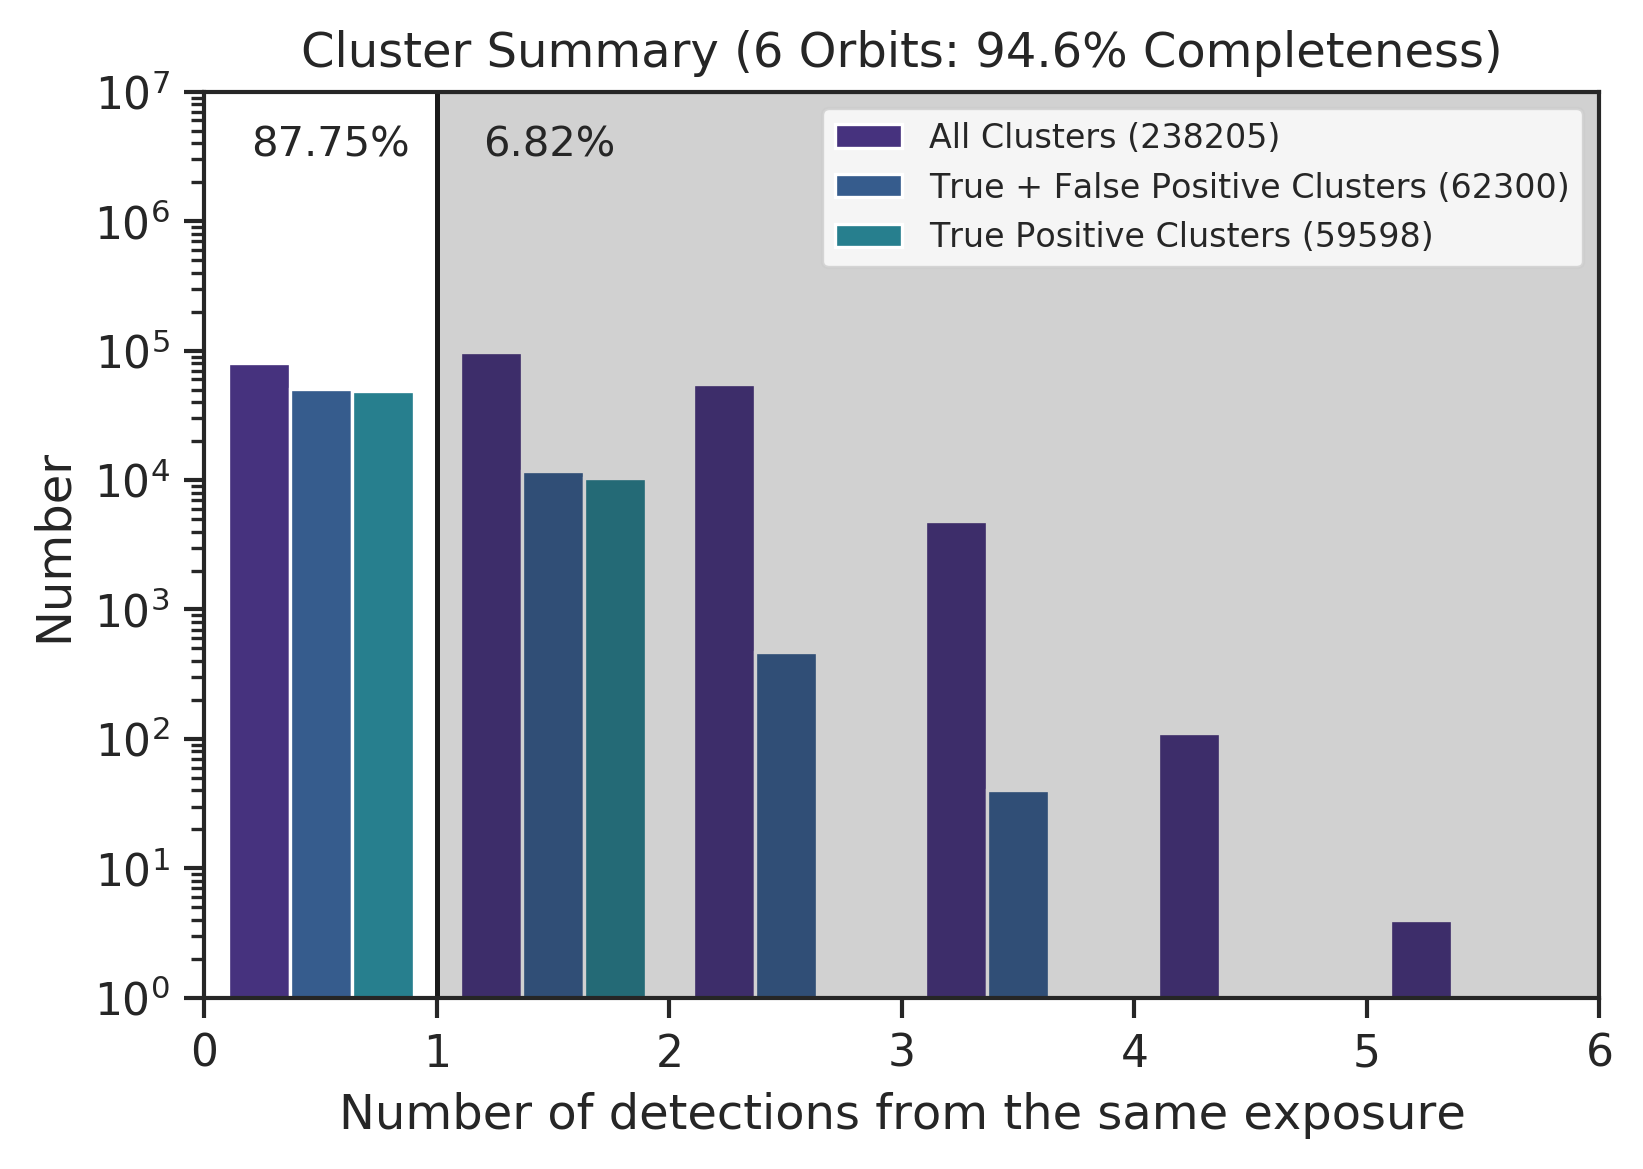

In [35]:
allClusters_projection["num_dupes"] = allClusters_projection["num_obs"] - allClusters_projection["num_visits"] 
accepted_clusters = allClusters_projection[(~allClusters_projection["linked_object"].isna()) & (~allClusters_projection["linked_object"].isin(["NS"]))]

a = set(accepted_clusters[accepted_clusters["pure"] == 1]["linked_object"].unique())
b = set(accepted_clusters[accepted_clusters["partial"] == 1]["linked_object"].unique())

fig, ax = plt.subplots(1, 1, dpi=DPI)
ax.hist([allClusters_projection["num_dupes"].values, 
         allClusters_projection[(allClusters_projection["partial"] == 1) | (allClusters_projection["pure"] == 1)]["num_dupes"].values,
         allClusters_projection[((allClusters_projection["partial"] == 1) | (allClusters_projection["pure"] == 1)) & (~allClusters_projection["linked_object"].isin(["NS"]))]["num_dupes"].values], 
        bins=range(7), 
        label=["All Clusters ({})".format(len(allClusters_projection)), 
               "True + False Positive Clusters ({})".format(len(allClusters_projection[(allClusters_projection["partial"] == 1) | (allClusters_projection["pure"] == 1)])),
               "True Positive Clusters ({})".format(len(allClusters_projection[((allClusters_projection["partial"] == 1) | (allClusters_projection["pure"] == 1)) & (~allClusters_projection["linked_object"].isin(["NS"]))]))])
ax.legend(fontsize=8)
ax.set_xlabel("Number of detections from the same exposure")
ax.vlines(1, 1, 10**7)
ax.set_yscale("log")
ax.set_ylim(1, 10**7)
ax.text(0.2, 10**6.5, "{:0.2f}%".format(len(a) / 18332 * 100))
ax.text(1.2, 10**6.5, "{:0.2f}%".format(len(b.difference(a)) / 18332 * 100))
ax.axvspan(1, 6, color="k", alpha=0.2)
ax.set_xlim(0, 6)
ax.set_title("Cluster Summary (6 Orbits: 94.6% Completeness)")
ax.set_ylabel("Number")
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "simulations_cluster_summary.{}".format(FORMAT)),
            bbox_inches='tight')